In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Hyperparameters
# learning_rate = 1e-4
batch_size = 32
epochs = 100
patience = 10  # for early stopping

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define the transformations, including converting to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to input size expected by DeiT
    transforms.ToTensor(),          # Convert PIL image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet standards
])

In [5]:
# Data Augmentation and Preprocessing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(),
    transforms.ColorJitter(),
    #transforms.RandomResizedCrop(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [6]:
# Load dataset
train_data = ImageFolder(root='D:\\PCa MRI\\db_spine-ok\\train', transform=transform_train)
val_data = ImageFolder(root='D:\\PCa MRI\\db_spine-ok\\val', transform=transform_val)
test_data = ImageFolder(root='D:\\PCa MRI\\db_spine-ok\\test', transform=transform_test)

In [7]:
# Split data into training and validation
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
# Import necessary libraries
from timm import create_model
import torch.nn as nn

# Load DeiT model with pre-trained weights
model = create_model('deit_base_distilled_patch16_224', pretrained=True)
# Modify both heads to have 6 output classes
model.head = nn.Linear(model.head.in_features, 6)
model.head_dist = nn.Linear(model.head_dist.in_features, 6)

## If the DeiT model has a distilled head, modify it as well
#if hasattr(model, 'head_dist'):
 #   model.head_dist = nn.Linear(model.head_dist.in_features, 6)

# Print model structure to verify changes
#print(model)


In [9]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [10]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [11]:
# Early Stopping Parameters
best_val_loss = np.inf
epochs_no_improve = 0
early_stop = False


In [12]:
# Lists to store metrics for plotting
train_loss_list = []
train_acc = []
val_loss_list = []
val_acc = []

In [13]:
# Training and Validation Loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training Phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Validation Phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    # Store metrics for plotting
    train_loss_list.append(avg_train_loss)
    train_acc.append(train_accuracy)
    val_loss_list.append(avg_val_loss)
    val_acc.append(val_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'deit_biasa.pth')  # Save best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        early_stop = True
        break

if not early_stop:
    torch.save(model.state_dict(), 'final_deit_biasa.pth')

Epoch 1/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:53<00:00,  4.45s/it]


Train Loss: 1.5955, Train Accuracy: 37.70%
Val Loss: 1.5144, Val Accuracy: 37.93%
Epoch 2/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:49<00:00,  4.41s/it]


Train Loss: 1.4586, Train Accuracy: 40.37%
Val Loss: 1.4771, Val Accuracy: 38.78%
Epoch 3/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 1.3897, Train Accuracy: 44.23%
Val Loss: 1.3370, Val Accuracy: 46.50%
Epoch 4/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 1.3374, Train Accuracy: 45.72%
Val Loss: 1.4352, Val Accuracy: 45.59%
Epoch 5/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 1.2627, Train Accuracy: 49.19%
Val Loss: 1.2955, Val Accuracy: 47.78%
Epoch 6/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:57<00:00,  4.48s/it]


Train Loss: 1.1646, Train Accuracy: 52.74%
Val Loss: 1.3145, Val Accuracy: 46.14%
Epoch 7/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 1.1113, Train Accuracy: 55.12%
Val Loss: 1.2220, Val Accuracy: 50.70%
Epoch 8/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 1.0671, Train Accuracy: 57.75%
Val Loss: 1.0898, Val Accuracy: 54.77%
Epoch 9/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:50<00:00,  4.42s/it]


Train Loss: 1.0248, Train Accuracy: 59.45%
Val Loss: 1.0674, Val Accuracy: 58.78%
Epoch 10/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.9319, Train Accuracy: 63.11%
Val Loss: 1.0571, Val Accuracy: 59.21%
Epoch 11/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.9070, Train Accuracy: 63.58%
Val Loss: 0.9903, Val Accuracy: 60.85%
Epoch 12/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.8592, Train Accuracy: 66.50%
Val Loss: 1.0075, Val Accuracy: 64.01%
Epoch 13/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.7700, Train Accuracy: 70.44%
Val Loss: 0.8875, Val Accuracy: 64.92%
Epoch 14/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.7932, Train Accuracy: 69.37%
Val Loss: 0.9428, Val Accuracy: 64.26%
Epoch 15/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.8048, Train Accuracy: 69.22%
Val Loss: 1.0391, Val Accuracy: 62.25%
Epoch 16/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.7516, Train Accuracy: 70.94%
Val Loss: 0.8731, Val Accuracy: 66.69%
Epoch 17/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.6985, Train Accuracy: 72.90%
Val Loss: 0.8407, Val Accuracy: 68.09%
Epoch 18/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:57<00:00,  4.48s/it]


Train Loss: 0.7055, Train Accuracy: 73.21%
Val Loss: 0.8264, Val Accuracy: 66.87%
Epoch 19/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.6481, Train Accuracy: 75.90%
Val Loss: 0.8293, Val Accuracy: 69.67%
Epoch 20/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.6081, Train Accuracy: 77.05%
Val Loss: 0.6714, Val Accuracy: 72.89%
Epoch 21/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:50<00:00,  4.42s/it]


Train Loss: 0.5560, Train Accuracy: 78.09%
Val Loss: 0.7119, Val Accuracy: 72.58%
Epoch 22/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.6355, Train Accuracy: 76.89%
Val Loss: 0.9785, Val Accuracy: 64.01%
Epoch 23/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.8568, Train Accuracy: 67.55%
Val Loss: 0.9567, Val Accuracy: 62.19%
Epoch 24/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.6305, Train Accuracy: 76.66%
Val Loss: 0.8692, Val Accuracy: 68.27%
Epoch 25/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.5362, Train Accuracy: 79.61%
Val Loss: 0.6143, Val Accuracy: 76.66%
Epoch 26/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:54<00:00,  4.45s/it]


Train Loss: 0.4465, Train Accuracy: 83.63%
Val Loss: 0.6444, Val Accuracy: 77.20%
Epoch 27/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.3991, Train Accuracy: 85.48%
Val Loss: 0.8584, Val Accuracy: 70.03%
Epoch 28/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.4250, Train Accuracy: 83.84%
Val Loss: 0.6268, Val Accuracy: 77.14%
Epoch 29/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:50<00:00,  4.42s/it]


Train Loss: 0.4223, Train Accuracy: 83.81%
Val Loss: 0.5952, Val Accuracy: 76.60%
Epoch 30/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.3252, Train Accuracy: 87.99%
Val Loss: 0.6496, Val Accuracy: 77.63%
Epoch 31/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.3168, Train Accuracy: 88.15%
Val Loss: 0.4980, Val Accuracy: 82.67%
Epoch 32/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.2922, Train Accuracy: 89.48%
Val Loss: 0.8083, Val Accuracy: 73.92%
Epoch 33/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.3768, Train Accuracy: 85.90%
Val Loss: 0.5384, Val Accuracy: 81.52%
Epoch 34/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.2699, Train Accuracy: 90.57%
Val Loss: 0.4861, Val Accuracy: 81.95%
Epoch 35/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:49<00:00,  4.41s/it]


Train Loss: 0.2558, Train Accuracy: 91.20%
Val Loss: 0.5038, Val Accuracy: 82.61%
Epoch 36/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.2512, Train Accuracy: 91.44%
Val Loss: 0.5854, Val Accuracy: 81.22%
Epoch 37/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:50<00:00,  4.42s/it]


Train Loss: 0.3291, Train Accuracy: 87.86%
Val Loss: 0.5639, Val Accuracy: 81.22%
Epoch 38/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:54<00:00,  4.45s/it]


Train Loss: 0.2432, Train Accuracy: 91.20%
Val Loss: 0.5892, Val Accuracy: 81.28%
Epoch 39/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:49<00:00,  4.41s/it]


Train Loss: 0.2550, Train Accuracy: 90.39%
Val Loss: 0.5764, Val Accuracy: 79.64%
Epoch 40/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.2392, Train Accuracy: 90.94%
Val Loss: 0.6962, Val Accuracy: 77.81%
Epoch 41/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.40s/it]


Train Loss: 0.3057, Train Accuracy: 88.67%
Val Loss: 0.4900, Val Accuracy: 83.40%
Epoch 42/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:49<00:00,  4.41s/it]


Train Loss: 0.2002, Train Accuracy: 92.53%
Val Loss: 0.5171, Val Accuracy: 82.67%
Epoch 43/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.2451, Train Accuracy: 91.38%
Val Loss: 0.6069, Val Accuracy: 79.94%
Epoch 44/100


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [08:48<00:00,  4.41s/it]


Train Loss: 0.2981, Train Accuracy: 89.19%
Val Loss: 0.5731, Val Accuracy: 80.30%
Early stopping triggered!


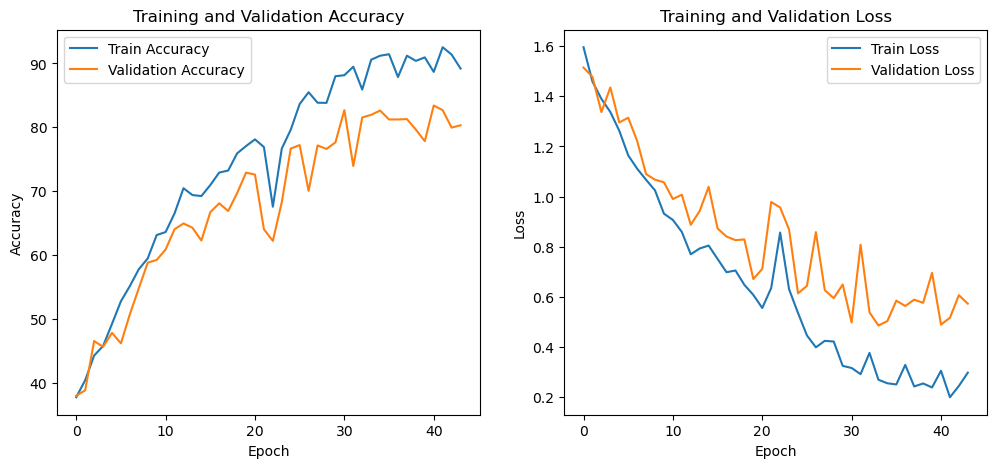

In [14]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [15]:
# Load the best model
model.load_state_dict(torch.load('deit_biasa.pth'))
model.eval()  # Set to evaluation mode

# Assume we have a test dataset
test_data = ImageFolder(root='D:\\PCa MRI\\db_spine-ok\\test', transform=transform_val)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Evaluate the model on the test set
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy of the best model: {test_accuracy:.2f}%")


C:\Users\USER\AppData\Local\Temp\ipykernel_18420\3090901471.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deit_biasa.pth'))


Test Accuracy of the best model: 83.66%


In [16]:
# Calculate Average Accuracy and Loss for Test Set
model.load_state_dict(torch.load('deit_biasa.pth'))
model.eval()

test_loss = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"\nAverage Train Loss: {np.mean(train_loss_list):.4f}, Average Train Accuracy: {np.mean(train_acc):.2f}%")
print(f"Average Val Loss: {np.mean(val_loss_list):.4f}, Average Val Accuracy: {np.mean(val_acc):.2f}%")
print(f"Average Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

C:\Users\USER\AppData\Local\Temp\ipykernel_18420\2913898898.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deit_biasa.pth'))



Average Train Loss: 0.6591, Average Train Accuracy: 74.48%
Average Val Loss: 0.8467, Average Val Accuracy: 68.16%
Average Test Loss: 0.4820, Test Accuracy: 83.66%


C:\Users\USER\AppData\Local\Temp\ipykernel_18420\1682596110.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('deit_biasa.pth'))


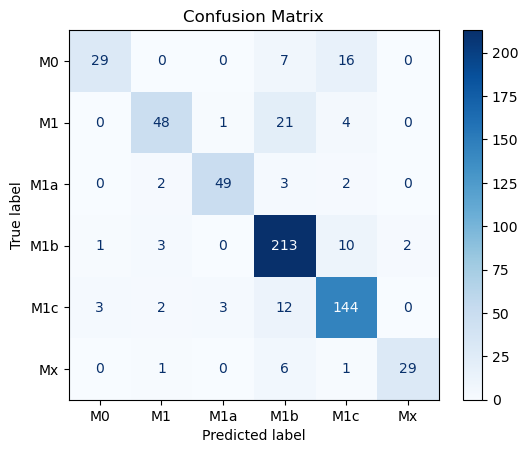

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load model terbaik
model.load_state_dict(torch.load('deit_biasa.pth'))
model.eval()

# List untuk menyimpan nilai sebenarnya (true) dan prediksi (predicted)
all_labels = []
all_preds = []

# Melakukan prediksi pada data uji
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Mendapatkan prediksi
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        # Menyimpan label sebenarnya dan prediksi
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Menghitung confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [18]:
from sklearn.metrics import classification_report

# Menghasilkan classification report
report = classification_report(all_labels, all_preds, target_names=val_data.classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

          M0       0.88      0.56      0.68        52
          M1       0.86      0.65      0.74        74
         M1a       0.92      0.88      0.90        56
         M1b       0.81      0.93      0.87       229
         M1c       0.81      0.88      0.84       164
          Mx       0.94      0.78      0.85        37

    accuracy                           0.84       612
   macro avg       0.87      0.78      0.81       612
weighted avg       0.84      0.84      0.83       612

